In [1]:
import sys  
# if you want to manage the code in a separate file use the following two lines
#sys.path.insert(0, r'C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\optimize')
#from model_tools import *

# Run SWMM5 using Script

The code block below does the following tasks,
- create a model from a template with a new set of parameters
- run the model
- extract the results


## Create a template file
We use the [jinja2](https://jinja.palletsprojects.com/en/3.0.x/) library to create a model file from a template file.

With Jinja you can write scripts in the template to automate more complicated tasks. In this example, we'll just use basic feature.

Say we sould like to run the model with different subcatchment impervious, slope and width parameters.

- create a sample model and save it
- open the *.inp file, and find the line where the values are defined for subcatchment (2) 
- replace the value with {{ name }}. Make sure to have space before and after the variable name
- save the *.inp as a template file

```
[SUBCATCHMENTS]
;;Name           Rain Gage        Outlet           Area     %Imperv  Width    %Slope   CurbLen  SnowPack        
;;-------------- ---------------- ---------------- -------- -------- -------- -------- -------- ----------------
2                RG1              10               22       {{ imp }}       {{ width }}      {{ slope }}     0                        
3                RG1              13               5        50       500      0.01     0                        
1                RG1              9                10       50       500      0.01     0  
```

## Create a model from a set of parameters

We'll use the render_input function to create a model with our parameters.

The code below will create an input file replacing the values of imp, width and slope with our values and save it as an input file.
```python
#template folder
tmp_folder = './template'
tmp_name = 'subcatchment.tpl'
data = {'imp': 50, 'width': 500, 'slope': 0.01}
out_inp = './model/test_model.inp'
render_input(tmp_folder,tmp_name,  data, out_inp)
```

## Run the model

We are going to use the [swmm.toolkit](https://github.com/OpenWaterAnalytics/swmm-python/tree/dev/swmm-toolkit) to run the model and then extract the results from the output file.

We specify the model base name (no extension), and the folder where the model input file is saved. It will run the model and generate the *.out and *.rpt files.

```python
model_name = 'test_model'
folder = './model'
run(model_name, folder)
```

## Extract the results
In this example, we'll extract the time series of subcatchment 2 runoff and save it as a csv file.

```python
out_file = './model/test_model.out'
of = OutFile(out_file)    
df = of.get_time_series('SUBCATCH', '2', ['RUNOFF_RATE'])
output.close(of.handle)
df.to_csv('./model/sub2_flow.csv)
```

# The Code
The code block has everything we need do the exercise.

In [6]:
# %load "C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\optimize\model_tools.py"
from jinja2 import Environment, FileSystemLoader
import logging
from swmm.toolkit import solver
from swmm.toolkit import output, shared_enum, output_metadata
import os
import pandas as pd
import datetime


def render_input(tmp_folder,tmp_name,  data, out_inp):
    '''
    render an input file using a template.
    tmp_folder: folde where the template inp file is.
    tmp_name: name of the template file
    data: the data to be applied to the template
    out_inp: the inp file with values applied
    '''
    env = Environment(loader=FileSystemLoader(tmp_folder))
    template = env.get_template(tmp_name)
    output_from_parsed_template = template.render(data)
    # to save the results
    with open(out_inp, "w") as fh:
        fh.write(output_from_parsed_template)
        # logging.info('inp created:%s' % out_inp)


def swmm_dt(days):
    # swmm saves dates as a number, here we convert swmm dates number to date
    # https://www.openswmm.org/Topic/4343/output-file-start-date-and-time-of-the-simulation
    t0 = pd.to_datetime('12/31/1899 00:00')
    t1 = t0 + datetime.timedelta(days=(days-1)) # I don't understand why I need to -1, hey it works. 
    return t1


class OutFile:
    def __init__(self, out_file):
        self.out_file = out_file
        self.handle = output.init()
        output.open(self.handle, out_file)
        self._get_objects()
        self._get_timeindex()
    
    def _get_objects(self):
        handle = self.handle
        sub_ct, node_ct, link_ct, a, b = output.get_proj_size(handle)

        objects = {'SUBCATCH':{}, 'NODE': {}, 'LINK': {}}

        for idx in range(sub_ct):
            objects['SUBCATCH'][output.get_elem_name(handle, shared_enum.ElementType.SUBCATCH, idx)] = idx
        
        for idx in range(node_ct):
            objects['NODE'][output.get_elem_name(handle, shared_enum.ElementType.NODE, idx)] = idx
        
        for idx in range(link_ct):
            objects['LINK'][output.get_elem_name(handle, shared_enum.ElementType.LINK, idx)] = idx
        
        self.objects = objects
    
    def get_object(self, obj_type, obj_name):
        return self.objects[obj_type][obj_name]

    def _get_timeindex(self):
        handle = self.handle
        timestep = output.get_times(handle, shared_enum.Time.REPORT_STEP)
        no_period =  output.get_times(handle, shared_enum.Time.NUM_PERIODS)
        self.no_period = no_period
        # convert the number to a date
        start_dt = swmm_dt(output.get_start_date(self.handle))

        # build the date range, pd.date_range can build a list of timestamps.
        time_index = pd.date_range(start=start_dt, periods=no_period, freq='%smin' % (timestep/60.0))
        self.report_time_index = time_index
    
    def get_time_series(self, obj_type, obj_name, parameters):
        handle = self.handle
        if obj_type == 'SUBCATCH':
            idx = self.get_object(obj_type, obj_name)
            data = {'datetime': self.report_time_index}
            for param in parameters:
                data[param] = output.get_subcatch_series(handle, idx, getattr(shared_enum.SubcatchAttribute, param), 0, self.no_period)
            df = pd.DataFrame(data)
            df.index = df['datetime']
            del df['datetime']
            return df
        elif obj_type == 'NODE':
            idx = self.get_object(obj_type, obj_name)
            data = {'datetime': self.report_time_index}
            for param in parameters:
                data[param] = output.get_node_series(handle, idx, getattr(shared_enum.NodeAttribute, param), 0, self.no_period)
            df = pd.DataFrame(data)
            df.index = df['datetime']
            del df['datetime']
            return df

def run_model(model_name, folder):
    inp_file = os.path.join(folder,  r"%s.inp" % model_name)
    rpt_file = os.path.join(folder,  r"%s.rpt" % model_name)
    out_file = os.path.join(folder,  r"%s.out" % model_name)
    solver.swmm_run(inp_file, rpt_file, out_file)
    of = OutFile(out_file)
    
    df = of.get_time_series('NODE', '1', ['TOTAL_INFLOW'])
    f2 = r"C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\optimize\data\model\obs.csv"
    df2 = pd.read_csv(f2, parse_dates=True)
    df2.index= pd.to_datetime(df2['datetime'])
    df3 = df.join(df2)
    mse = sum([x*x for x in (df3['obs'] - df3['TOTAL_INFLOW']).values])
    # peak_flow = df['TOTAL_INFLOW'].max()
    # with open(os.path.join(folder, '%s.txt' % model_name), 'w') as o:
    #     o.write('-------\n')
    #     o.write('S10PEAKFLOW %.4f' % peak_flow)
    output.close(of.handle)
    return mse


def create_model(out_inp, tmp_folder, tmp_name, x):
    data = dict(zip(['area', 'width', 'slope', 'esurf', 'a1', 'b1'], x))
    render_input(tmp_folder,tmp_name,  data, out_inp)


def run(model_name, folder):
    inp_file = os.path.join(folder,  r"%s.inp" % model_name)
    rpt_file = os.path.join(folder,  r"%s.rpt" % model_name)
    out_file = os.path.join(folder,  r"%s.out" % model_name)
    solver.swmm_run(inp_file, rpt_file, out_file)
    

def get_results(out_file, obj_type, obj_name, param):
    of = OutFile(out_file)    
    # df = of.get_time_series('NODE', '1', ['TOTAL_INFLOW'])
    df = of.get_time_series(obj_type, obj_name, param)
    output.close(of.handle)
    return df

def delete_model(folder, model_name):
    """delete all the modeling files

    Args:
        folder (str): folder of the swmm5 model
        model_name (str): base name of the model
    """
    for ext in ['.inp', '.rpt', '.out']:
        f = os.path.join(folder, '%s%s' % (model_name, ext))
        if os.path.exists(f):
            os.remove(f)
    

<AxesSubplot:xlabel='datetime'>

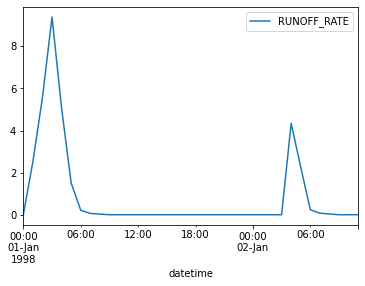

In [13]:
#create an new inp file
ws = r'C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\optimize\data'

model_name = 'test'
out_inp = os.path.join(ws, 'model/%s.inp' % model_name)
tmp_folder = os.path.join(ws, 'template')
tmp_name = 'test.tpl'
data = {'imp': 50, 'width': 500, 'slope': 0.01}

render_input(tmp_folder,tmp_name,  data, out_inp)

model_folder = os.path.join(ws, 'model')
run(model_name, model_folder)

out_file = os.path.join(ws, 'model/%s.out' % model_name)
of = OutFile(out_file)    
df = of.get_time_series('SUBCATCH', '2', ['RUNOFF_RATE'])
output.close(of.handle)
out_csv = os.path.join(ws, 'model/%s.csv' % model_name)
df.to_csv(out_csv)
df.plot()
